# Implementing Linear Regression from Scratch
## Samar Kamat

I will be taking inspiration from Andrew Ng's Machine Learning Specialization for this project as a whole, and will be using a few mathematical formulae from there.

### Linear Regression

Linear regression is a type of supervised learning in which a model is made to fit a line that best matches a dataset, in order to make predictions based on certain inputs. I will be making use of multiple linear regression, which is a type of linear regression that involves multiple input variables (features) and an output variable (target). I will be making use of a matrix (2D NumPy array) for the features and a vector (1D NumPy array) for the target.

This notebook will be covering z-score normalization for feature scaling, batch gradient descent for finding the optimal parameters to make a good prediction, and a scikit-learn implementation of the same model.

### Dataset
This data set contains details of 10,000 students, along with 5 features (input variables) including their previous scores, extracurricular activities, sleep hours and number of question papers practiced. The target variable (output) is their performance index (percentage). 

**Data set**: https://www.kaggle.com/datasets/nikhil7280/student-performance-multiple-linear-regression

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy, math

In [188]:
# Loading the data set
df = pd.read_csv('Student_Performance.csv')
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [189]:
# converting the 'Extracurricular Activities' column values from 'Yes' and 'No' to 1 and 0
df['Extracurricular Activities'] = df['Extracurricular Activities'].map({'Yes': 1, 'No': 0})

In [190]:
X_df = df.iloc[:,0:4] # including all examples of all features variables
print(X_df.head())
y_df = df.iloc[:, -1] # taking the last column as our target
print(y_df.head())

   Hours Studied  Previous Scores  Extracurricular Activities  Sleep Hours
0              7               99                           1            9
1              4               82                           0            4
2              8               51                           1            7
3              5               52                           1            5
4              7               75                           0            8
0    91.0
1    65.0
2    45.0
3    36.0
4    66.0
Name: Performance Index, dtype: float64


In [191]:
features = X_df.columns.tolist()
print(f"The features are: {features}")
target = y_df.name
print(f"Target is: {target}")

The features are: ['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours']
Target is: Performance Index


In [192]:
# converting the data frames into the training set
# 2D array or matrix for features (X_train) that has rows as examples, and columns as features
X_train = X_df.to_numpy()
y_train = y_df.to_numpy()
print(f"X_train shape: {X_train.shape}")
print(X_train[:5])
print(f"y_train shape: {y_train.shape}")
print(y_train[:5])

X_train shape: (10000, 4)
[[ 7 99  1  9]
 [ 4 82  0  4]
 [ 8 51  1  7]
 [ 5 52  1  5]
 [ 7 75  0  8]]
y_train shape: (10000,)
[91. 65. 45. 36. 66.]


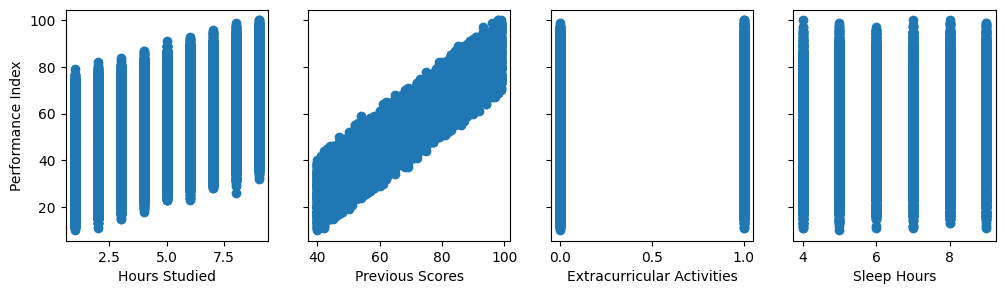

In [193]:
# Plotting the target against all of the features to show their relationship
fig, ax = plt.subplots(1, 4, figsize=(12, 3), sharey=True)
for f in range(len(ax)):
    ax[f].scatter(X_train[:, f], y_train)
    ax[f].set_xlabel(features[f])
ax[0].set_ylabel(target)
plt.show()

# the relationships below, tell us about how the features correlate with the target
# we can understand that the first two features have more importance as they correlate 
# better with the target, and we can see that at the end, when the model assigns weights.

### z-score normalization
Normalization is used to scale all of the features to similar ranges, so that the upcoming steps like gradient descent are performed much more quickly and efficiently.
z-score normalization ensures all of the features will have a mean of 0 and standard deviation of 1.

$$x^{(i)}_j = \dfrac{x^{(i)}_j - \mu_j}{\sigma_j} \tag{1}$$ 

Here, j is the feature, i is the example (row). $µ_j$ is the mean of all the examples of feature j and $\sigma_j$ is the standard deviation of feature j.
$$
\begin{align}
\mu_j &= \frac{1}{m} \sum_{i=0}^{m-1} x^{(i)}_j \tag{2}\\
\sigma^2_j &= \frac{1}{m} \sum_{i=0}^{m-1} (x^{(i)}_j - \mu_j)^2  \tag{3}
\end{align}
$$

In [194]:
def z_score_normalization(X_train):
    mu = np.mean(X_train, axis=0) # find the mean for all the columns (features)
    sigma = np.std(X_train, axis=0) # finding the standard deviation for the same
    X_norm = (X_train - mu)/sigma
    return X_norm

### Implementing batch gradient descent involves using this formula

The equations for the parameters 'w' (weights for each of the features) and the bias 'b':

$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline\;
& w_j := w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{4}  \; & \text{for j = 0..n-1}\newline
&b\ \ := b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}$$

The above steps are repeated simulteneously (the updated values of w or b do not affect eachother until the next iteration of gradient descent). Here, n is the number of features (columns), and j represents each individual feature.

$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{5}  \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{6}
\end{align}
$$

Here, m is the number of training examples (rows). $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$ is the target value.

### Why gradient descent?

Gradient descent is useful for a linear regression to check the current parameters and features, to then move towards a more optimal combination of these parameters. Essentially, we are trying to minimize our cost, given by the cost function $J(\mathbf{w},b)$. The cost determines how good our predictions are. The lesser the cost, the better the prediction.  This can be done efficiently with gradient descent. In this implementation I will be using batch gradient descent, which involves going through the whole dataset on each iteration of gradient descent, for a more accurate descent (change in parameters).

In [195]:
# This code is finding the derivatives as given in equations 5 and 6
def batch_gradient(X_train, y_train, w, b):
    # w is a numpy 1D array (vector) and b is a scalar
    m,n = X_train.shape
    d_dw = np.zeros((n,))
    d_db = 0.

    for i in range(m):
        error = (np.dot(X_train[i], w) + b) - y_train[i]
        for j in range(n):
            d_dw[j] += error * X_train[i][j]
        d_db += error
    d_dw = (d_dw) / m
    d_db = (d_db) / m
    
    return d_dw, d_db        

### The cost function

This function must be implemented in order to check if our gradient descent is working properly. We will call this function within the batch gradient descent function, to show the reduction in cost iteratively.

The cost function is given by the formula below:

$$J(\mathbf{w},b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})^2 \tag{7}$$ 
where:
$$ f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)} + b  \tag{8} $$ 

In [196]:
def cost_function(X_train, y_train, w, b):
    m = X_train.shape[0]
    total_cost = 0
    for i in range(m):
        squared_error = ((np.dot(X_train[i], w) + b) - y_train[i])**2
        total_cost += squared_error
    average_cost = (total_cost)/(2*m)
    return average_cost

In [197]:
# This code is finding the updating the parameter values
# This happens every iteration until convergence, as given by equation 4
def batch_gradient_descent(X_train, y_train, w_in, b_in, alpha, batch_gradient, cost_function, iterations):
    w = copy.deepcopy(w_in)
    b = b_in
    cost_history = []

    for i in range(iterations):
        if i < 100000:
            cost = cost_function(X_train, y_train, w, b)
            cost_history.append(cost)
            d_dw, d_db = batch_gradient(X_train, y_train, w, b)
            w = w - (alpha*d_dw)
            b = b - (alpha*d_db)

        if i % math.ceil(iterations / 10) == 0:
            print(f"Iterations {i:4d}; Cost {cost_history[-1]:8.2f}")
    return w, b    

In [198]:
n = X_train.shape[1]
w_in = np.zeros((n,)) 
b_in = 0.
iterations = 1000
alpha = 1.0e-2

X_train = z_score_normalization(X_train)
w_final, b_final = batch_gradient_descent(X_train, y_train, w_in, b_in, alpha, batch_gradient, cost_function, iterations)

print(f"The initial weights were: {w_in}")
print(f"The bias was: {b_in}")
print(f"The final weights are: {w_final}")
print(f"The bias is: {b_final}")

Iterations    0; Cost  1709.43
Iterations  100; Cost   231.36
Iterations  200; Cost    32.99
Iterations  300; Cost     6.36
Iterations  400; Cost     2.78
Iterations  500; Cost     2.30
Iterations  600; Cost     2.24
Iterations  700; Cost     2.23
Iterations  800; Cost     2.23
Iterations  900; Cost     2.23
The initial weights were: [0. 0. 0. 0.]
The bias was: 0.0
The final weights are: [ 7.39619141 17.66559478  0.31375815  0.81729271]
The bias is: 55.222415876496


### Plotting

Plotting only 50 plots to ensure visibility, the predictions will still be plotted based on the model trained on 10,000 data points

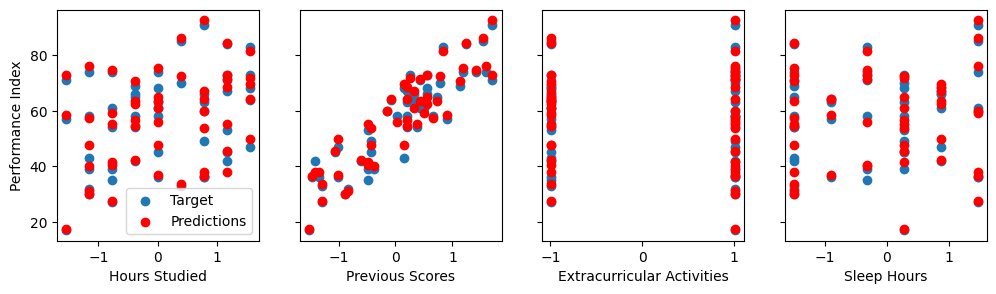

In [199]:
m = X_train.shape[0]
predictions = np.zeros(m)
for i in range(m):
    predictions[i] = np.dot(X_train[i], w_final) + b_final

fig, ax = plt.subplots(1, 4, figsize=(12,3), sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:50,i], y_train[:50], label = "Target")
    ax[i].scatter(X_train[:50,i], predictions[:50], label = "Predictions", color = "red")
    ax[i].set_xlabel(features[i])
ax[0].set_ylabel(target)
ax[0].legend()
plt.show()

### Implementing the same model in scikit-learn 
Scikit-learn is an opern-source, commonly used toolkit, which contains the implementations of many machine learning algorithms.

In [200]:
from sklearn.linear_model import SGDRegressor # Stochastic Gradient Descent model
from sklearn.preprocessing import StandardScaler # z-score normalization

In [201]:
# loading the data into numpy arrays
X_sk = X_df.to_numpy()
y_sk = y_df.to_numpy()
print(X_sk[:5])
print(y_sk[:5])
print(f"Peak to peak range for all features (columns): {np.ptp(X_sk, axis=0)}")

[[ 7 99  1  9]
 [ 4 82  0  4]
 [ 8 51  1  7]
 [ 5 52  1  5]
 [ 7 75  0  8]]
[91. 65. 45. 36. 66.]
Peak to peak range for all features (columns): [ 8 59  1  5]


In [202]:
# z-score normalization of input data
scaler = StandardScaler()
X_sk = scaler.fit_transform(X_sk)
print(X_sk)
print(f"Normalized peak to peak range for all features: {np.ptp(X_sk, axis=0)}")

[[ 0.77518771  1.70417565  1.01045465  1.45620461]
 [-0.38348058  0.72391268 -0.98965352 -1.49229423]
 [ 1.16141048 -1.06362569  1.01045465  0.27680507]
 ...
 [ 0.38896495  0.7815752   1.01045465  0.86650484]
 [ 1.54763324  1.5888506   1.01045465  0.27680507]
 [ 0.77518771  0.26261245 -0.98965352  0.86650484]]
Normalized peak to peak range for all features: [3.08978212 3.40208916 2.00010817 2.94849884]


In [206]:
model = SGDRegressor(max_iter=1000)
model.fit(X_sk, y_sk)
w_sk = model.coef_
b_sk = model.intercept_[0]
print(f"The final weights given by scikit-learn: {w_sk}")
print(f"The bias given by scikit-learn: {b_sk}")
print(f"The final weights from the my model: {w_final}")
print(f"The bias from my model: {b_final}")

The final weights given by scikit-learn: [ 7.3908623  17.63315064  0.24983823  0.81939889]
The bias given by scikit-learn: 55.21053139309919
The final weights from the my model: [ 7.39619141 17.66559478  0.31375815  0.81729271]
The bias from my model: 55.222415876496


In [207]:
y_pred = model.predict(X_sk)
# could also do y_pred = np.dot(X_sk, w_sk) + b_sk

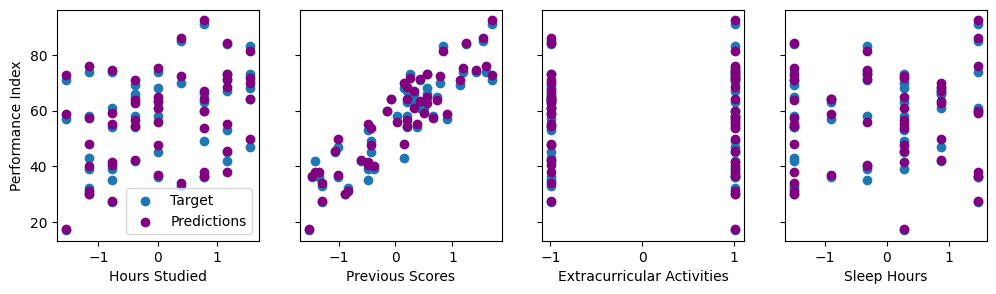

In [208]:
# plotting 50 points for the scikit-learn predictions
fig, ax2 = plt.subplots(1, 4, figsize=(12, 3), sharey=True)

for i in range(len(ax2)):
    ax2[i].scatter(X_sk[:50,i], y_sk[:50], label="Target")
    ax2[i].scatter(X_sk[:50,i], y_pred[:50], label="Predictions", color="purple")
    ax2[i].set_xlabel(features[i])
ax2[0].set_ylabel(target)
ax2[0].legend()
plt.show()

### Credits
There you go, a complete implementation of a linear regression model from scratch. Stay tuned for more 'from scratch' projects. A big thanks to Andrew Ng for his wonderful machine learning specialization. Do check it out, I learnt all of this from there.